In [51]:
from scipy.io import loadmat
import matplotlib.pyplot as plt

import numpy as np
import os
import collections

In [54]:
def my_savefig(file_name):
    plt.savefig(os.path.join(os.getenv('DA_FIGURES', ''), f"{file_name}.pdf"))
    plt.savefig(os.path.join(os.getenv('DA_FIGURES', ''), f"{file_name}.svg"))

In [2]:
def Fr(w, p1, q1, p2, q2):
    cond_1 = w <= -2 * q2 / p2
    expr_1 = p2 * w + q2
    cond_2 = w <= 0
    expr_2 = - p2 ** 2 / (4 * q2) * w ** 2
    cond_3 = w <= 2 * q1 / p1
    expr_3 = p1 ** 2 / (4 * q1) * w ** 2
    cond_4 = True
    expr_4 = p1 * w - q1

    if cond_1:
        return expr_1
    elif cond_2:
        return expr_2
    elif cond_3:
        return expr_3
    elif cond_4:
        return expr_4

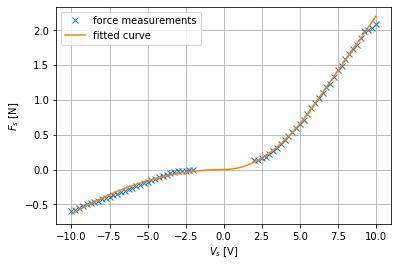

In [4]:
matfile = loadmat('../matlab/rotor_force_analysis/data_for_python')
vsfs_data = matfile['combined_normalized_data']
p1 = float(matfile['p1_opt'])
q1 = float(matfile['q1_opt'])
p2 = float(matfile['p2_opt'])
q2 = float(matfile['q2_opt'])

vs_plot = np.linspace(-10, 10, 101)
Fs_plot = np.array([Fr(vs, p1, q1, p2, q2) for vs in vs_plot])

plt.figure()
plt.plot(vsfs_data[:, 0], vsfs_data[:, 1], 'x', label='force measurements')
plt.plot(vs_plot, Fs_plot, label='fitted curve')
plt.legend()
plt.grid()
plt.xlabel('$V_s$ [V]')
plt.ylabel('$F_s$ [N]')

my_savefig('force_curve')
plt.show()

In [3]:
def load_meas(file_name):
    MeasData = collections.namedtuple('MeasData', ['t', 'vf', 'vb', 'meas_phi', 'meas_eps', 'meas_lamb', 'enable_ramping', 'est_phi', 'est_eps', 'est_lamb', 'est_dphi', 'est_deps', 'est_dlamb', 'est_phi_off'])
    
    file = loadmat(f"../matlab/measurements/{file_name}")
    log = file['log']
    
    t = log['time'][0][0].flatten()
    
    values = log['signals'][0][0]['values'][0]
    
    vf = values[0].flatten()
    vb = values[1].flatten()
    meas_phi = values[2].flatten()
    meas_eps = values[3].flatten()
    meas_lamb = values[4].flatten()
    enable_ramping = values[5].flatten() if len(values) >= 6 else np.zeros(len(t))
    est_phi = values[6].flatten() if len(values) >= 7 else np.zeros(len(t))
    est_eps = values[7].flatten() if len(values) >= 8 else np.zeros(len(t))
    est_lamb = values[8].flatten() if len(values) >= 9 else np.zeros(len(t))
    est_dphi = values[9].flatten() if len(values) >= 10 else np.zeros(len(t))
    est_deps = values[10].flatten() if len(values) >= 11 else np.zeros(len(t))
    est_dlamb = values[11].flatten() if len(values) >= 12 else np.zeros(len(t))
    est_phi_off = values[12].flatten() if len(values) >= 13 else np.zeros(len(t))
    
    return MeasData(t, vf, vb, meas_phi, meas_eps, meas_lamb, enable_ramping, est_phi, est_eps, est_lamb, est_dphi, est_deps, est_dlamb, est_phi_off)

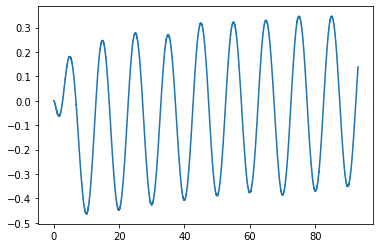

In [10]:
test = load_meas('../parameter_estimation/exp4_lamb_feedback_sine_a20_f0_1.mat')

plt.plot(test.t, test.meas_lamb)

In [56]:
def load_est(file_name):
    EstData = collections.namedtuple('EstData', ['params', 'clips'])
    ClipData = collections.namedtuple('ClipData', ['meas_t', 'meas_u', 'meas_y', 'sim_y'])
    
    file = loadmat(f"../matlab/{file_name}")
    
    params = file['params'].flatten()
    clips = []
    
    for i in range(len(file['clips'][0])):
        clip = file['clips'][0,i]
        meas_t = clip['meas_t'].flatten()
        meas_u = clip['meas_u']
        meas_y = clip['meas_y']
        sim_y = clip['sim_y']
        
        clips.append(ClipData(meas_t, meas_u, meas_y, sim_y))
    
    return EstData(params, clips)


In [76]:
def plot_est(file_name, clip_nr, angle, with_input=True):
    deg = np.pi / 180
    data = load_est(file_name)
    
    if with_input:
        plt.subplot(211)
    plt.plot(data.clips[clip_nr].meas_t, data.clips[clip_nr].meas_y/deg, label='measured')
    plt.plot(data.clips[clip_nr].meas_t, data.clips[clip_nr].sim_y/deg, label='simulated')
    plt.xlabel('$t$ [s]')
    plt.ylabel(f"$\\{angle}$ [°]")
    plt.grid()
    plt.legend()
    
    if with_input:
        plt.subplot(212)
        plt.plot(data.clips[clip_nr].meas_t, data.clips[clip_nr].meas_u)
        plt.xlabel('$t$ [s]')
        plt.ylabel('$V$ [V]')
        plt.grid()
        plt.legend(['$V_f$', '$V_b$'])

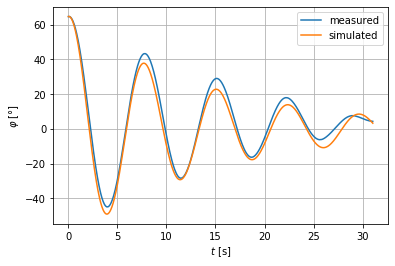

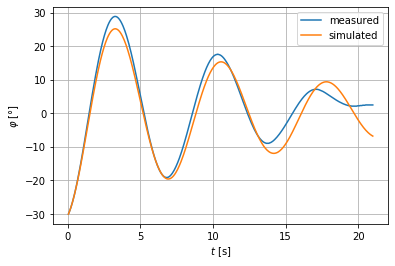

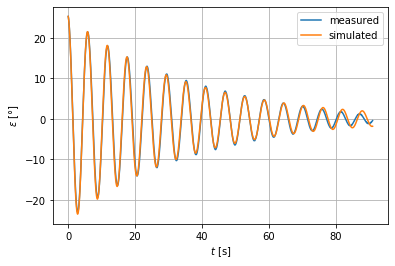

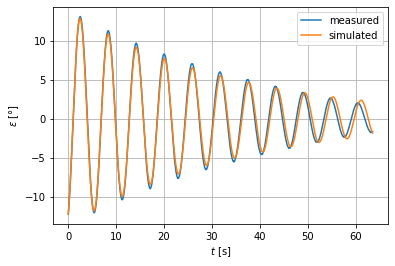

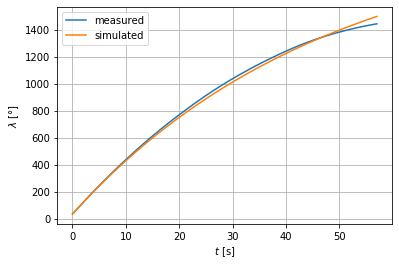

In [82]:
plt.figure()
plot_est('est_mu_phi.mat', 0, 'varphi', False)
my_savefig('est_mu_phi_0')

plt.figure()
plot_est('est_mu_phi.mat', 1, 'varphi', False)
my_savefig('est_mu_phi_1')

plt.figure()
plot_est('est_mu_eps.mat', 0, 'varepsilon', False)
my_savefig('est_mu_eps_0')

plt.figure()
plot_est('est_mu_eps.mat', 1, 'varepsilon', False)
my_savefig('est_mu_eps_1')

plt.figure()
plot_est('est_mu_lamb.mat', 0, 'lambda', False)
my_savefig('est_mu_lamb')

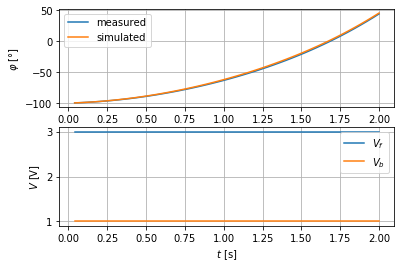

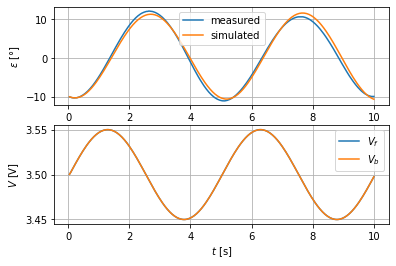

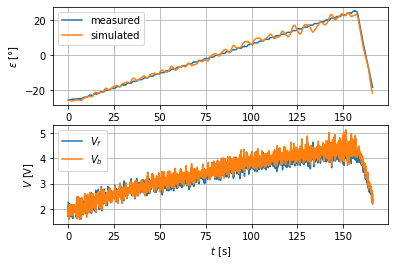

In [93]:
# p_eps_1: good looking 58, 57, 53, 
# p_eps_2 and p_eps_3: 2

plt.figure()
plot_est('est_p_phi_1_p_phi_2.mat', 3, 'varphi', True)
my_savefig('est_p_phi_1_p_phi_2_clip_3')

plt.figure()
plot_est('est_p_eps_1.mat', 53, 'varepsilon', True)
my_savefig('est_p_eps_1_clip_53')

plt.figure()
plot_est('est_p_eps_2_p_eps_3_NICE.mat', 0, 'varepsilon', True)
my_savefig('est_p_eps_2_p_eps_3_NICE')